# Time dependent photon flux

This notebook shows how to force an atmosphere with a time-dependent UV photon flux.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import numba as nb

from PhotochemPy import PhotochemPy, io

In [2]:
# We will use Modern Earth template
pc = PhotochemPy('../input/templates/ModernEarth/species.dat', \
                 '../input/templates/ModernEarth/reactions.rx', \
                 '../input/templates/ModernEarth/settings.yaml', \
                 '../input/templates/ModernEarth/atmosphere.txt', \
                 '../input/templates/ModernEarth/Sun_Now.txt')

The time-dependent photon flux will be determined by a callback function (i.e. a function which is given to PhotochemPy). The callback function must have very specific inputs and outputs! It must be a function in the C programing language, which looks exactly like this:

```C
void time_dependent_flux_fcn(double tn, int nw, double *photon_flux)
{
  // rest of function goes here...
}
```

We can create C callbacks functions from Python with the [numba library](https://numba.pydata.org/numba-doc/latest/user/cfunc.html):

```python
import numba as nb

@nb.cfunc(nb.types.void(nb.types.double,nb.types.int32,nb.types.CPointer(nb.types.double)))
def time_dependent_flux_fcn(tn, nw, photon_flux):
    # Rest of function goes here.
    # It returns nothing.
```

`photon_flux` is an OUTPUT to `time_dependent_flux_fcn`. It is an array of length `nw` which must be filled with the photon flux (photons/cm$^2$/s) hitting the atmosphere. `tn` is time in seconds into the simluation. It's possible to use this function to describe any time-evolving photon flux. Below is a simple example.

In [3]:
# it is useful to define the `cfunc` within another function.
# this way, the c_func will inherit the data passed into the higher scope. 
# For example, here we pass in `flux_mean`, which becomes a constant embedded in
# `photon_flux_cfunc` when we make the cfunc.

def make_callback(flux_mean, amplitude, period_s):
    
    @nb.cfunc(nb.types.void(nb.types.double,nb.types.int32,nb.types.CPointer(nb.types.double)))
    def photon_flux_cfunc(tn, nw, photon_flux):
        for i in range(nw):
            # here I choose to oscillate the photon flux in each bin about a mean value
            # I also dampen this oscillation over time
            photon_flux[i] = flux_mean[i] + \
                             amplitude*flux_mean[i]*np.sin(2*np.pi*tn/(period_s)) *\
                             np.exp(-tn/(2*period_s))
    
    return photon_flux_cfunc

day = 24*60*60
flux_m = pc.data.flux.copy() # photon flux from "Sun_Now.txt"
amp = 0.9 # amplitude of oscillation
period = 100*day # Period of oscillation (in seconds)

# make the function
photon_flux_cfunc = make_callback(flux_m, amp, period)

**ONE CRITICAL THING!!!**: The function `photon_flux_cfunc` MUST be smooth as a function of time. The integrator will be not opperate properly otherwise. So, if you have a big data file which describes how the photon flux changes over time, you must actively interpolate within `photon_flux_cfunc`, using a smoothing interpolator like cubic spine. DO NOT just use linear interpolation. It will prevent `photon_flux_cfunc` from being smooth.

Here we tell PhotochemPy that we are using a time dependent photon flux, and give it the function:

In [4]:
pc.data.time_dependent_photon_flux = True
pc.data.photon_flux_ptr = photon_flux_cfunc.address 

Finally, we evolve the atmosphere over time using the CVODE BDF integrator (better than Backward Euler). This will put results into the binary file `test_photon_flux.dat`

In [5]:
teval = np.linspace(0,4*period,600)
t0 = 0.0

# it is sometimes better not run pc.evolve within jupyter notebooks.
# Jupyter gets upset with print statements from Fortran. Instead, just 
# copy-paste all this code into a .py file and run it with `python my_script.py`

# An alternative is to disable printing from Fortran into notebooks. I like do this.
# you can do this by creating this file: "~/.ipython/profile_default/ipython_config.py"
# and adding this line to it: "c.IPKernelApp.capture_fd_output = False"

pc.evolve(t0,pc.vars.usol_init,teval,outfile='test_photon_flux.dat', \
nsteps = 1000000, amount2save=1, overwrite=True)

In [6]:
# read the results
sol = io.read_evolve_output("test_photon_flux.dat")

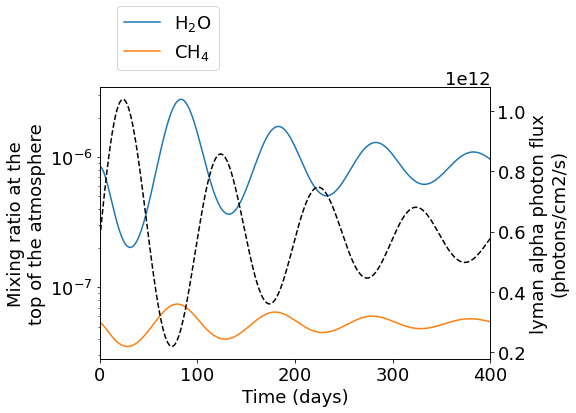

In [7]:
# plot the results
plt.rcParams.update({'font.size': 18})
fig,ax = plt.subplots(1,1,figsize=[7,5])
fig.patch.set_facecolor("w")

nt = len(sol['time'])
nw = len(pc.data.flux)
flux = np.zeros((nw,),np.float64)
all_flux = np.zeros((nw,nt),np.float64)
for i in range(nt):
    photon_flux_cfunc(sol['time'][i], nw, flux.data)
    all_flux[:,i] = flux

ax.plot(sol['time']/day, sol['H2O'][:,-1], label='H$_2$O')
ax.plot(sol['time']/day, sol['CH4'][:,-1], label='CH$_4$')
ax.set_xlabel('Time (days)')
ax.set_xlim(0,np.max(sol['time']/day))

ax.set_yscale('log')
ax.set_ylabel('Mixing ratio at the\ntop of the atmosphere')
ax.legend(ncol=1,bbox_to_anchor=(0.02,1.03),loc='lower left')

ax1 = ax.twinx()
    
ax1.plot(sol['time']/day, all_flux[0,:],'k--')
ax1.set_ylabel('lyman alpha photon flux\n(photons/cm2/s)')

plt.show()

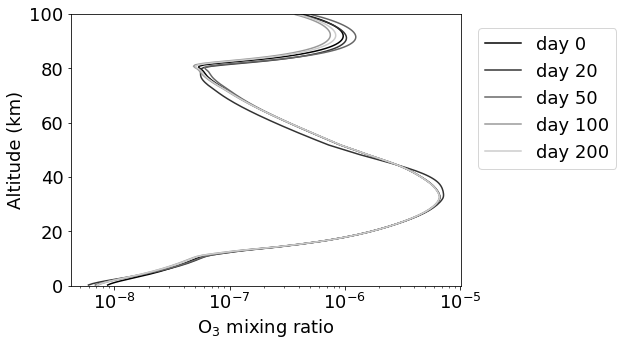

In [8]:
plt.rcParams.update({'font.size': 18})
fig,ax = plt.subplots(1,1,figsize=[7,5])
fig.patch.set_facecolor("w")

times = np.array([0,20,50,100,200])*day
inds = []
for t in times:
    inds.append(np.argmin(np.abs(t-sol['time'])))

for i,ind in enumerate(inds):
    ax.plot(sol['O3'][ind,:], sol['alt']/1e5, c=str(i/len(inds)), label='day %i'%(times[i]/day))
    
ax.legend(ncol=1,bbox_to_anchor=(1.02,0.98),loc='upper left')
    
ax.set_xscale('log')
ax.set_ylim(0,100)
ax.set_ylabel('Altitude (km)')
ax.set_xlabel('O$_3$ mixing ratio')

plt.show()